In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import numpy as np

dataset_dir = "/content/drive/MyDrive/braai_cnn/"
dataset_path = dataset_dir + "ztf_dataset_split.npz"
data = np.load(dataset_path)
data

NpzFile '/content/drive/MyDrive/braai_cnn/ztf_dataset_split.npz' with keys: X_flat_train, X_flat_test, X_train, X_test, y_train...

In [3]:
# X
X_flat_test = data["X_flat_test"]
X_test = data["X_test"]

# y
y_train = data["y_train"]
y_test = data["y_test"]

X_flat_test.shape, X_test.shape, y_train.shape, y_test.shape

((9592, 11907), (9592, 3, 63, 63), (28776,), (9592,))

In [4]:
unique_values, counts = np.unique(np.concatenate((y_train, y_test), axis=0), return_counts=True)
for value, count in zip(unique_values, counts):
  print(f"Value {value}: {count}")

Value 0: 20274
Value 1: 18094


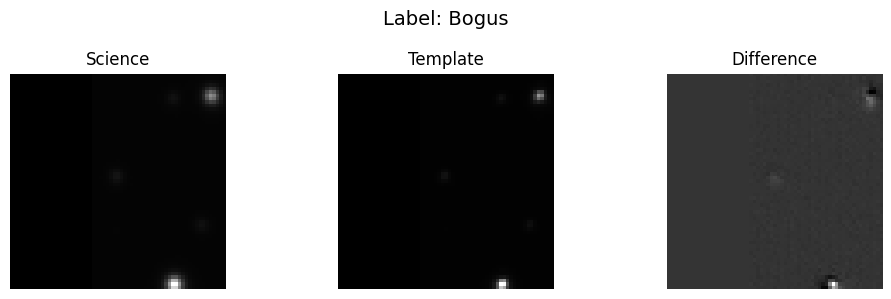

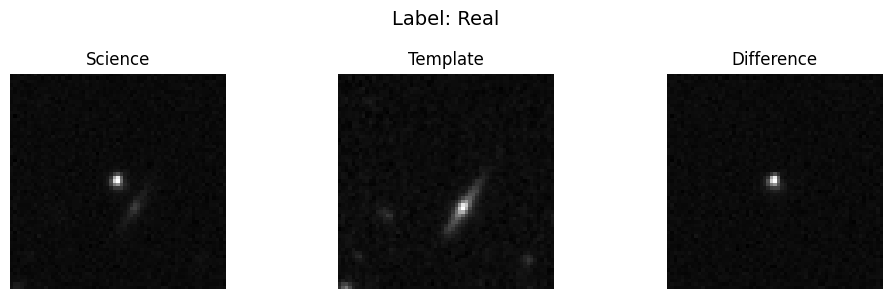

In [5]:
import matplotlib.pyplot as plt

def plot_img(sample, label):
  channels = ['Science', 'Template', 'Difference']
  fig, axs = plt.subplots(1, 3, figsize=(10, 3))
  for i in range(3):
    axs[i].imshow(sample[i], cmap='gray')
    axs[i].set_title(channels[i])
    axs[i].axis('off')

  fig.suptitle(f"Label: {'Real' if label == 1 else 'Bogus'}", fontsize=14)
  plt.tight_layout()
  plt.show()

plot_img(X_test[0], y_test[0])
plot_img(X_test[1], y_test[1])

## Load models and preds

### Logistic Regression

In [30]:
import pickle
models_dir = "/content/drive/MyDrive/braai_cnn/models/"

with open(models_dir + 'lrc_model.pkl', 'rb') as file:
  lrc_model = pickle.load(file)

lrc_probs = lrc_model.predict_proba(X_flat_test)[:, 1]
lrc_preds = (lrc_probs > 0.5).astype(int)

### Random Forest

In [31]:
with open(models_dir + 'rfc_model.pkl', 'rb') as file:
  rfc_model = pickle.load(file)

rfc_probs = rfc_model.predict_proba(X_flat_test)[:, 1]
rfc_preds = (rfc_probs > 0.5).astype(int)

### PyTorch CNN

In [15]:
import os
os.chdir(dataset_dir)

In [16]:
import torch
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [17]:
X_test_tensor = torch.tensor(X_test, dtype=torch.float32).to(device)

In [19]:
from pt_cnn_layers import PyTorchCNN

pytorch_cnn = PyTorchCNN().to(device)
state = torch.load('models/pytorch_cnn.pt', map_location=device)
pytorch_cnn.load_state_dict(state['model'])
pytorch_cnn.eval()

PyTorchCNN(
  (conv1_1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv1_2): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (dropout1): Dropout(p=0.25, inplace=False)
  (conv2_1): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2_2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool2): MaxPool2d(kernel_size=2, stride=4, padding=0, dilation=1, ceil_mode=False)
  (dropout2): Dropout(p=0.25, inplace=False)
  (fc1): Linear(in_features=2048, out_features=256, bias=True)
  (dropout3): Dropout(p=0.5, inplace=False)
  (fc2): Linear(in_features=256, out_features=1, bias=True)
)

In [20]:
batch_size = 64
num_samples_tensor = X_test_tensor.shape[0]
pt_probs = []

with torch.no_grad():
  for i in range(0, num_samples_tensor, batch_size):
    batch = X_test_tensor[i : i+batch_size]
    pred = pytorch_cnn(batch)
    pt_probs.append(pred.cpu())

pt_probs = torch.cat(pt_probs).squeeze().numpy()
pt_preds = (pt_probs > 0.5).astype(int)

### Numpy CNN

In [23]:
import cupy as cp
X_test_cp = cp.array(X_test)

In [24]:
from np_cnn_layers import NumpyCNN

np_cnn = NumpyCNN()
np_cnn.load("models/numpy_cnn.npz", (16, 3, 63, 63))

/usr/local/lib/python3.11/dist-packages/cupyx/jit/_interface.py:173: FutureWarning: cupyx.jit.rawkernel is experimental. The interface can change in the future.
  cupy._util.experimental('cupyx.jit.rawkernel')


Model from models/numpy_cnn.npz loaded into NumpyCNN


In [25]:
batch_size = 16
num_samples_cp = X_test_cp.shape[0]
cp_probs = []

for i in range(0, num_samples_cp, batch_size):
  batch = X_test_cp[i : i+batch_size]
  batch_preds = np_cnn.predict(batch)
  cp_probs.append(batch_preds)

cp_probs = cp.asnumpy(cp.concatenate(cp_probs, axis=0))
cp_probs = cp_probs.flatten()
cp_preds = (cp_probs > 0.5).astype(int)

In [32]:
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix
)

def eval_model(y_true, y_pred, y_probs):
  return {
      "Accuracy": accuracy_score(y_true, y_pred),
      "Precision": precision_score(y_true, y_pred),
      "Recall": recall_score(y_true, y_pred),
      "F1 Score": f1_score(y_true, y_pred),
      "ROC AUC": roc_auc_score(y_true, y_probs),
      "Confusion Matrix": confusion_matrix(y_true, y_pred)
  }

In [33]:
results_lrc = eval_model(y_test, lrc_preds, lrc_probs)
results_rfc = eval_model(y_test, rfc_preds, rfc_probs)
results_pt = eval_model(y_test, pt_preds, pt_probs)
results_cp = eval_model(y_test, cp_preds, cp_probs)

In [34]:
import pandas as pd

metrics_df = pd.DataFrame([
    results_lrc,
    results_rfc,
    results_cp,
    results_pt
], index=["Logistic Regression", "Random Forest", "NumPy CNN", "PyTorch CNN"])

metrics_df.drop(columns=["Confusion Matrix"], inplace=True)

metrics_df

,Accuracy,Precision,Recall,F1 Score,ROC AUC
Logistic Regression,0.661697,0.644049,0.631660,0.637794,0.711283
Random Forest,0.775021,0.771652,0.742649,0.756872,0.855148
NumPy CNN,0.795767,0.743171,0.866239,0.800000,0.891631
PyTorch CNN,0.812448,0.748904,0.906036,0.820010,0.911653


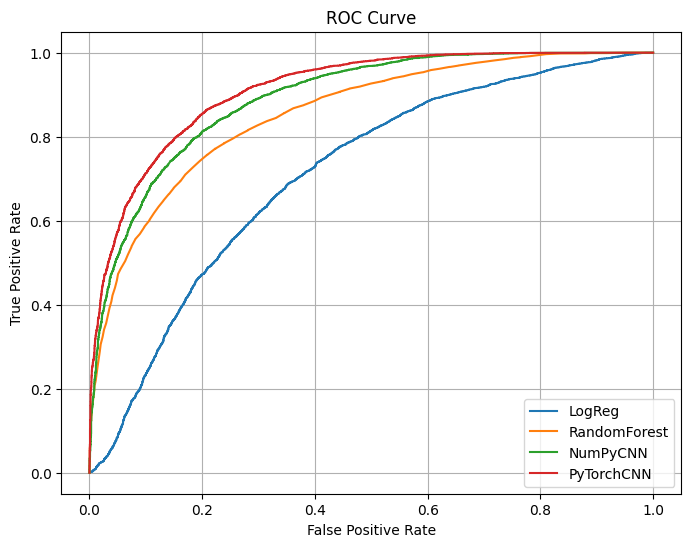

In [35]:
from sklearn.metrics import roc_curve, precision_recall_curve

def plot_curves(y_true, model_outputs, labels, curve_type):
  plt.figure(figsize=(8, 6))

  for y_probs, label in zip(model_outputs, labels):
    if curve_type == "ROC":
      fpr, tpr, thresholds = roc_curve(y_true, y_probs)
      plt.plot(fpr, tpr, label=label)
      plt.xlabel("False Positive Rate")
      plt.ylabel("True Positive Rate")
    else:
      precision, recall, _ = precision_recall_curve(y_true, y_probs)
      plt.plot(recall, precision, label=label)
      plt.xlabel("Recall")
      plt.ylabel("Precision")

  plt.title(f"{curve_type} Curve")
  plt.legend()
  plt.grid(True)
  plt.show()

plot_curves(y_test, [lrc_probs, rfc_probs, cp_probs, pt_probs],
            ["LogReg", "RandomForest", "NumPyCNN", "PyTorchCNN"],
            curve_type='ROC')

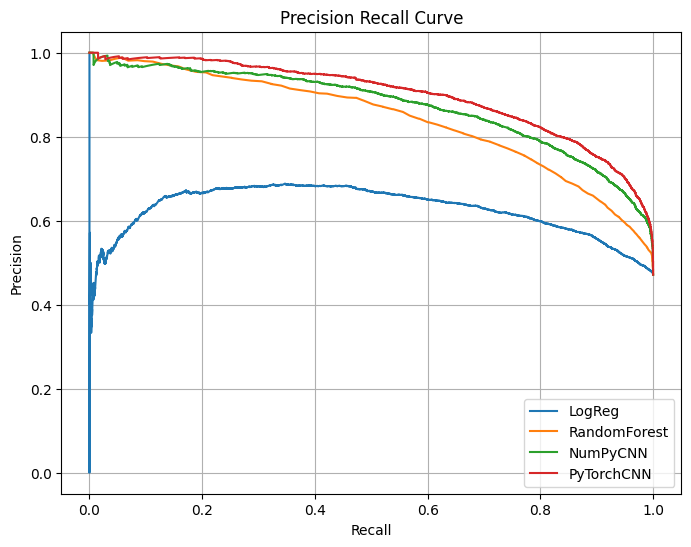

In [37]:
plot_curves(y_test, [lrc_probs, rfc_probs, cp_probs, pt_probs],
            ["LogReg", "RandomForest", "NumPyCNN", "PyTorchCNN"],
            curve_type='Precision Recall')

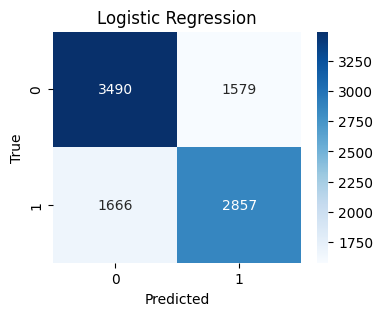

In [39]:
import seaborn as sns

def plot_confusion(matrix, title):
  plt.figure(figsize=(4, 3))
  sns.heatmap(matrix, annot=True, fmt='d', cmap='Blues')
  plt.title(title)
  plt.xlabel("Predicted")
  plt.ylabel("True")
  plt.show()

plot_confusion(results_lrc["Confusion Matrix"], "Logistic Regression")

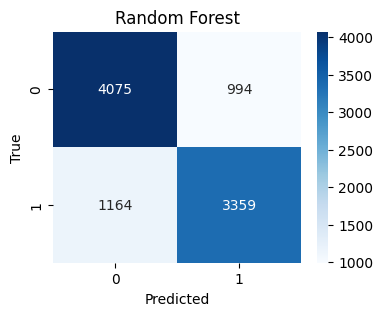

In [40]:
plot_confusion(results_rfc["Confusion Matrix"], "Random Forest")

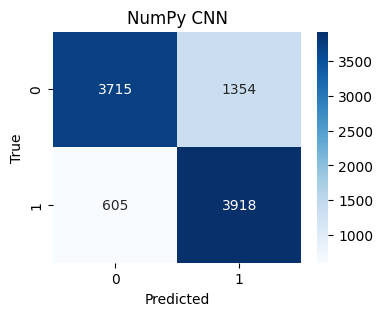

In [41]:
plot_confusion(results_cp["Confusion Matrix"], "NumPy CNN")

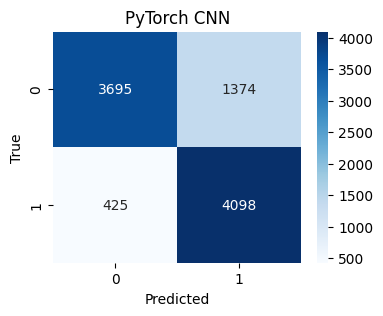

In [42]:
plot_confusion(results_pt["Confusion Matrix"], "PyTorch CNN")